In [1]:
import pandas as pd

# llegim dataset original

df = pd.read_csv("qualitat_aire.csv")


# guardem màxim i mitjana diària

df['MITJANA_DIARIA'] = df[['01h', '02h', '03h', '04h', '05h', '06h', '07h', '08h',
                            '09h', '10h', '11h', '12h', '13h', '14h', '15h', '16h',
                            '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h']].mean(axis=1, skipna=True)

df['MAXIM_DIARI'] = df[['01h', '02h', '03h', '04h', '05h', '06h', '07h', '08h',
                         '09h', '10h', '11h', '12h', '13h', '14h', '15h', '16h',
                         '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h']].max(axis=1, skipna=True)


# eliminem columnes horàries

df = df.drop(['01h', '02h', '03h', '04h', '05h', '06h', '07h', '08h', '09h',
              '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h',
              '19h', '20h', '21h', '22h', '23h', '24h'], axis=1)

# eliminem columnes que no necessitarem

columnes_a_eliminar = ['CODI EOI', 'CODI INE', 'CODI COMARCA', 'Georeferència']

df = df.drop(columnes_a_eliminar, axis=1)

df['DATA'] = pd.to_datetime(df['DATA'])




/var/folders/d9/hpj0n4ds4lb3546xfwjxjmcm0000gq/T/ipykernel_70173/3997109218.py:5: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("qualitat_aire.csv")
/Users/genis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '30/11/2023' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/genis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '29/11/2023' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/genis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '28/11/2023' in DD/MM/YYYY format. Provide format or specify infer_datetime_form

In [2]:
# eliminem dades antigues o no completes

rang_dates_per_contaminant = df.groupby('CONTAMINANT')['DATA'].agg(['min', 'max'])

contaminants_a_eliminar = ['HCNM', 'HCT', 'HCl', 'PS', 'Cl2']

df = df[~df['CONTAMINANT'].isin(contaminants_a_eliminar)]

In [3]:
contaminants_seleccionats = ['NO2', 'O3', 'PM10', 'PM2.5']

df_seleccionat = df[df['CONTAMINANT'].isin(contaminants_seleccionats)]

df_seleccionat = df_seleccionat[df_seleccionat['NOM COMARCA'] == "Osona"]

df_seleccionat = df_seleccionat[df_seleccionat['DATA'].dt.year > 2017]


In [4]:
limits_qualitat_aire = {
    'NO2': {'A': 40, 'B': 90, 'C': 120, 'D': 230, 'E': 340, 'F': float('inf')},
    'PM10': {'A': 20, 'B': 40, 'C': 50, 'D': 100, 'E': 150, 'F': float('inf')},
    'PM2.5': {'A': 10, 'B': 20, 'C': 25, 'D': 50, 'E': 75, 'F': float('inf')},
    'O3': {'A': 50, 'B': 100, 'C': 130, 'D': 240, 'E': 380, 'F': float('inf')}
}


# Funció que assigna la lletra segons els límits
def assigna_lletra(contaminant, mitjana_diaria, maxim_diari):
    limits = limits_qualitat_aire.get(contaminant, {})
    
    if contaminant == 'NO2':
        return next((lletra for lletra, limit in limits.items() if maxim_diari <= limit), None)
    else:
        return next((lletra for lletra, limit in limits.items() if mitjana_diaria <= limit), None)

# Apliquem la funció per crear una nova columna 'ICQA'
df_seleccionat['ICQA'] = df_seleccionat.apply(lambda row: assigna_lletra(row['CONTAMINANT'], row['MITJANA_DIARIA'], row['MAXIM_DIARI']), axis=1)
     
df_seleccionat = df_seleccionat.reset_index(drop=True)

df_seleccionat.to_csv('qualitat_aire_osona.csv', index=False)


In [5]:
df['DATA'] = pd.to_datetime(df['DATA'])
df['ANY'] = df['DATA'].dt.year
df['MES'] = df['DATA'].dt.month

df_final = df.groupby(['NOM ESTACIO', 'ANY', 'MES', 'CONTAMINANT', 'TIPUS ESTACIO', 'AREA URBANA', 'MUNICIPI', 'NOM COMARCA', 'UNITATS', 'LONGITUD', 'LATITUD', 'ALTITUD'], as_index=False).agg({
    'MITJANA_DIARIA': 'mean',
    'MAXIM_DIARI': 'max'
})

df_final = df_final.rename(columns={'MITJANA_DIARIA': 'MITJANA_MENSUAL', 'MAXIM_DIARI': 'MAXIM_MENSUAL'})

df_final['DATE'] = pd.to_datetime(df_final['ANY'].astype(str) + df_final['MES'].astype(str), format='%Y%m')

df_final.to_csv('qualitat_aire_mensual.csv', index=False)


In [6]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [7]:
taula_contingencia = pd.crosstab(index=[df_seleccionat['CONTAMINANT'], df_seleccionat['DATA'].dt.year], columns=df_seleccionat['ICQA'], margins=False)

print(taula_contingencia)

ICQA                A    B   C   D  E  F
CONTAMINANT DATA                        
NO2         2018  499  221   4   0  0  0
            2019  493  231   4   0  0  0
            2020  603  116   0   0  0  0
            2021  616  102   4   0  0  0
            2022  601   93   7   1  0  0
            2023  726  156   1   0  0  0
O3          2018  562  516   7   0  0  0
            2019  527  543  20   0  0  0
            2020  659  435   2   0  0  0
            2021  605  489   1   0  0  0
            2022  525  524  20   0  0  0
            2023  335  612   7   0  0  0
PM10        2018  276  304  19   9  0  0
            2019  281  365  41  30  2  0
            2020  372  298  23  17  0  0
            2021  244  377  43  41  1  2
            2022  253  373  44  54  1  0
            2023  322  266  40  22  1  0
PM2.5       2023  108  124  12  14  1  0


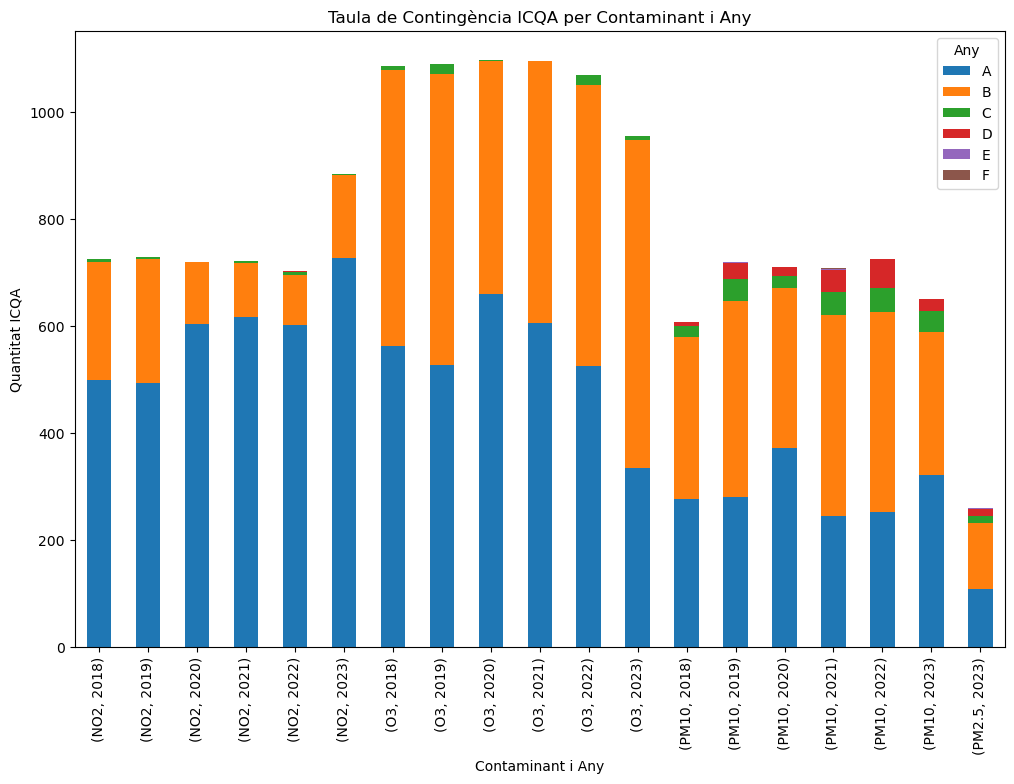

Tona (Zona Esportiva)    2160
Manlleu                  2154
Vic                       327
Name: NOM ESTACIO, dtype: int64

In [8]:
taula_contingencia.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Taula de Contingència ICQA per Contaminant i Any')
plt.xlabel('Contaminant i Any')
plt.ylabel('Quantitat ICQA')
plt.legend(title='Any', loc='upper right')

plt.show()

df_seleccionat[df_seleccionat['CONTAMINANT'] == 'NO2']['NOM ESTACIO'].value_counts()


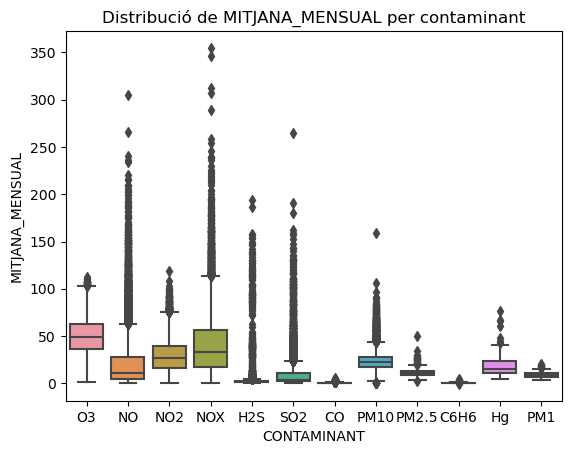

In [9]:

# Boxplots per a diferents contaminants

sns.boxplot(x='CONTAMINANT', y='MITJANA_MENSUAL', data=df_final)
plt.title('Distribució de MITJANA_MENSUAL per contaminant')
plt.show()


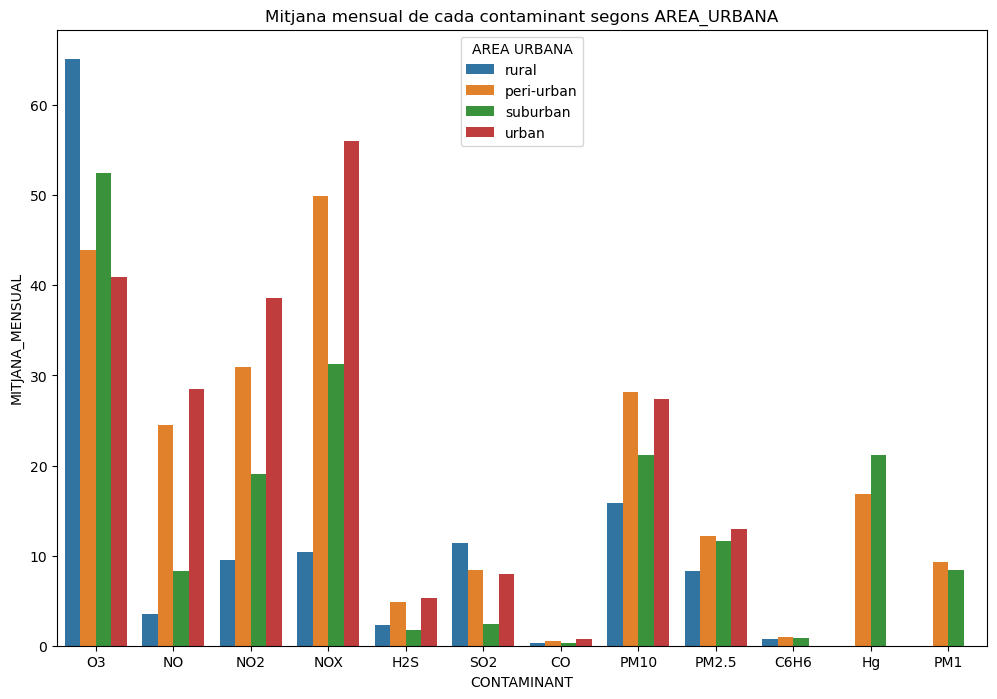

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(x='CONTAMINANT', y='MITJANA_MENSUAL', hue='AREA URBANA', data=df_final, ci=None)
plt.title('Mitjana mensual de cada contaminant segons AREA_URBANA')
plt.xlabel('CONTAMINANT')
plt.ylabel('MITJANA_MENSUAL')
plt.show()

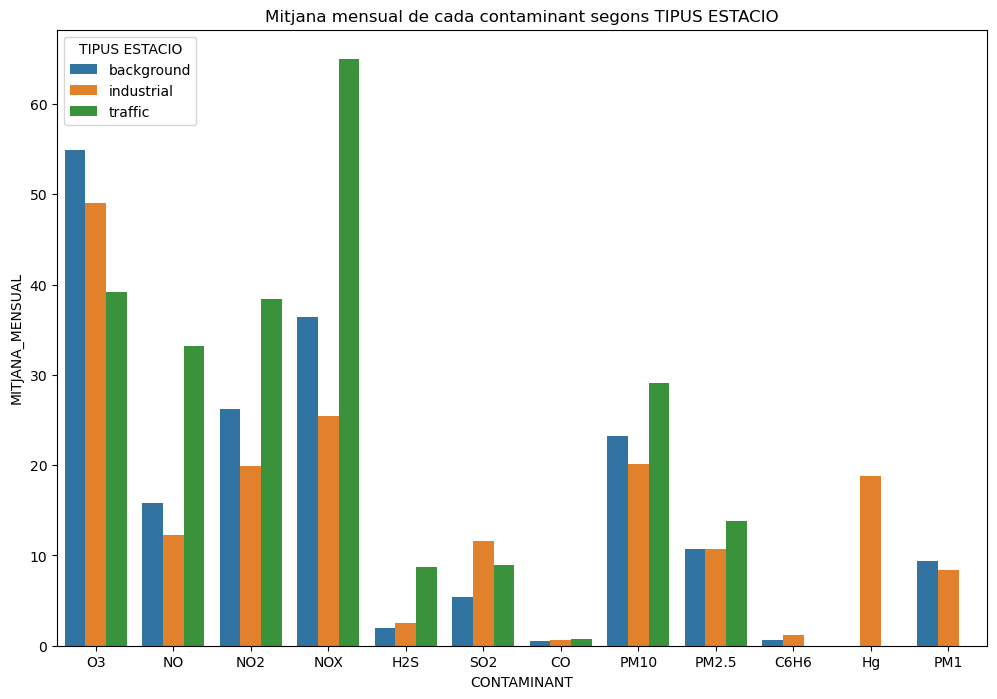

In [11]:
plt.figure(figsize=(12, 8))
sns.barplot(x='CONTAMINANT', y='MITJANA_MENSUAL', hue='TIPUS ESTACIO', data=df_final, ci=None)
plt.title('Mitjana mensual de cada contaminant segons TIPUS ESTACIO')
plt.xlabel('CONTAMINANT')
plt.ylabel('MITJANA_MENSUAL')
plt.show()

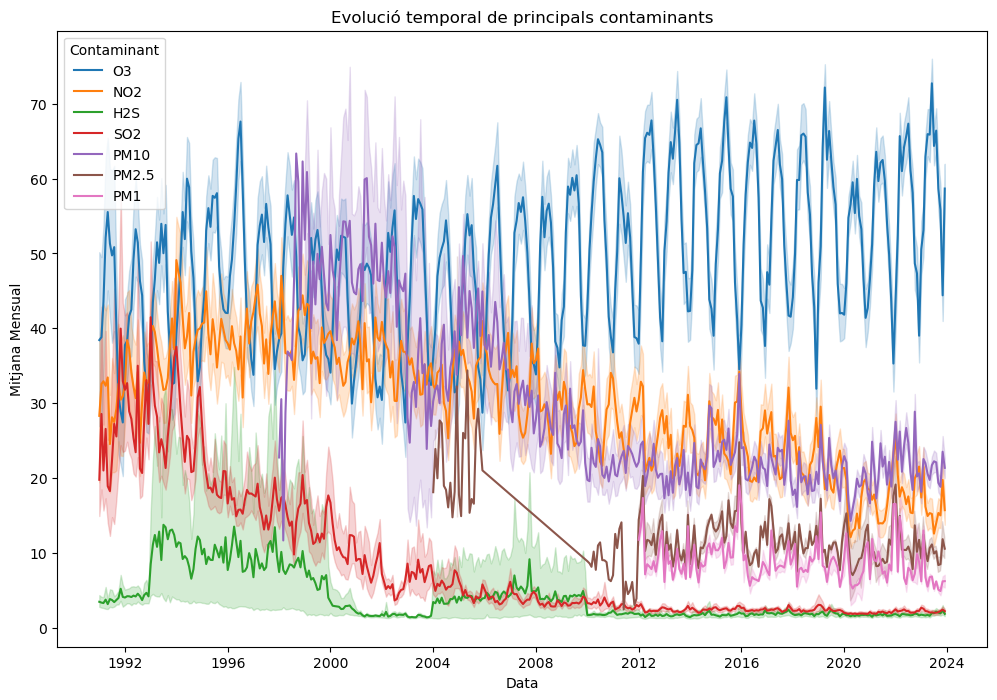

In [12]:
contaminants_seleccionats = ['NO2', 'PM10', 'PM2.5', 'PM1', 'O3', 'SO2', 'H2S']
df_contaminants_seleccionats = df_final[df_final['CONTAMINANT'].isin(contaminants_seleccionats)]

plt.figure(figsize=(12, 8))
sns.lineplot(x='DATE', y='MITJANA_MENSUAL', hue='CONTAMINANT', data=df_contaminants_seleccionats)

plt.title('Evolució temporal de principals contaminants')
plt.xlabel('Data')
plt.ylabel('Mitjana Mensual')
plt.legend(title='Contaminant', loc='upper left')
plt.show()

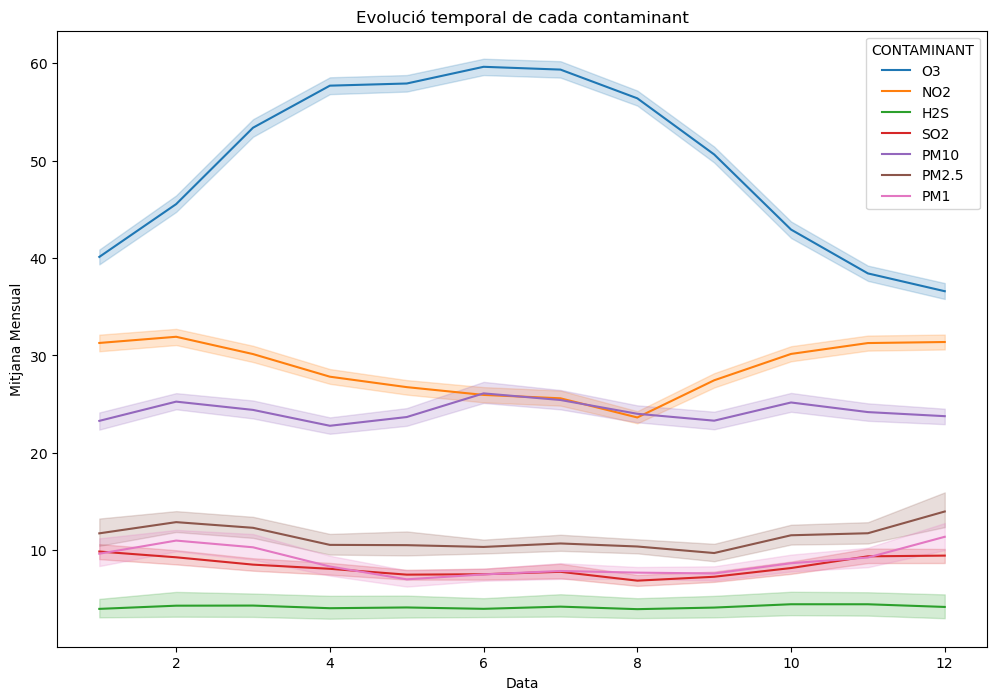

In [13]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='MES', y='MITJANA_MENSUAL', hue='CONTAMINANT', data=df_contaminants_seleccionats)

plt.title('Evolució temporal de cada contaminant')
plt.xlabel('Data')
plt.ylabel('Mitjana Mensual')
plt.show()